In [1]:
#IMPORT
import numpy as np
import scipy as sp
import sys
import os
from pathlib import Path

current_dir = Path().resolve()

src_path = current_dir.parent / "src"

# Add to sys.path
sys.path.append(str(src_path))

#import utils_avalanches as ava
from tvb.simulator.lab import *
import functions_simulator as fun
import os
import matplotlib.pylab as plt
import matplotlib.cm as cm
from scipy import stats
import Utils as fx
#import utils_kuramoto as kur
from functions import *

current_directory = os.getcwd()

# Run simulations

In [5]:
# CONNECTIVITY for only feedforward coupling between populations A--->B
# weights
a2=np.identity(2)
a2-=a2
a2[1,0]=1

# CONNECTIVITY for feedback coupling between populations A<--->B
# a2=np.identity(2)
# a2-=a2
# a2[1,0]=1
# a2[0,1]=1

# Setup the connectivity for the simulator
Allen_SC = connectivity.Connectivity(
    weights= a2,
    tract_lengths=a2+a2.T,
    speed= np.asarray(np.infty),
    centres = np.random.rand(3,2),
    region_labels=np.asarray([i for i in range(len(a2))],dtype='<U128')) 
Allen_SC.configure()

SC=Allen_SC.weights
nroi=len(SC)
Cortical_labels=np.array([ 0,  1])

In [6]:
G=0.05
mean_speed=np.infty #np.mean(Allen_SC.tract_lengths)/3   # conduction speed

Fixed_parameters_hybrid={'J':1.25, 
                         'a_par':[0.964, 0.967, 0.97, 0.973, 0.976, 0.979, 0.982],
                         'sigma':0.6775, 
                         'omega':1., 
                         'v':mean_speed, 
                         'dt':.05, 
                         'sim_length':60000,
                         'N':0.0001,
                         'noise_seed':0,
                         'Gs':G}

J = Fixed_parameters_hybrid['J']
sigma = Fixed_parameters_hybrid['sigma']
omega = Fixed_parameters_hybrid['omega']
v = Fixed_parameters_hybrid['v']
sim_length = Fixed_parameters_hybrid['sim_length']
dt = Fixed_parameters_hybrid['dt'] 
NN=Fixed_parameters_hybrid['N'] 
noise_seed=Fixed_parameters_hybrid['noise_seed'] 

a_par=Fixed_parameters_hybrid['a_par']

In [7]:
# Define Out Folder
# out_folder='myfolder/'

In [ ]:
for ia, a in enumerate(a_par):
    print(ia, end='\r')
    for ib, b in enumerate(a_par):
        # Define the function to be retried
        def call_function():
            # Your function call here
            t, r, psi, input = fun.simulate_network_conduct_seed_wholeR(Allen_SC, J, [a,b], sigma, omega, G, NN, noise_seed, v, sim_length, dt, verbose=True)
            return t, r, psi, input
        
        # Retry the function call
        result = retry_function(call_function, attempts=25, delay=1)
        
        if result is not None:
            t, r, psi, input = result
    
            R=r[5000:,:][:,:]
            PSI=psi[5000:,:][:,:]
            INPUT=input[5000:,:][:,:]
            my_dict = {'R':R,'PSI':PSI,'INPUT':INPUT}
    
            #with open(out_folder + 'data_a%d_b%d.pkl'%(ia,ib), 'wb') as file:
            #    pickle.dump(my_dict, file)
        
        else:
            print(f"Function call failed for a value {a} and {b}. Skipping...")

# Evaluate Autocorrelation at 1ms (AC1)

In [10]:
out_folder='/Volumes/LaCie2/fufo/data/Interim/Bozzo/2025/2pop/'

# === Allocate result arrays ===
shape = (len(a_par), len(a_par))

AC1_RA = np.full(shape, np.nan)
AC1_RB = np.full(shape, np.nan)

# === Loop over saved files ===
for ia, a in enumerate(a_par):
    print(ia)
    for ib, b in enumerate(a_par):
        fname = f"data_a{ia}_b{ib}.pkl"
        fpath = os.path.join(out_folder, fname)  # Replace with your folder path
        if not os.path.exists(fpath):
            continue
        with open(fpath, 'rb') as f:
            data = pickle.load(f)
        R = data['R']
        if R.shape[0] < 1000:
            continue  # skip too short timeseries

        RA = R[:, 0]
        RB = R[:, 1]

        AC1_RA[ia, ib] = AC1(RA)
        AC1_RB[ia, ib] = AC1(RB)

0
1
2
3
4
5
6


# Results

In [11]:
# === Plot results ===
metrics = {r'$\Delta$AC1': (AC1_RB-AC1_RA.T)/AC1_RA.T}

In [41]:
# # Save to file
# with open('../figures/Fig2/metrics_unidirect.pkl', 'wb') as f:
#     pickle.dump(metrics, f)

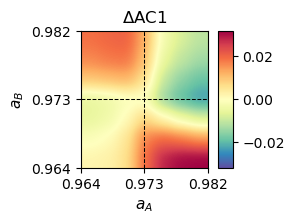

In [12]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

fig = plt.figure(figsize=(10, 4.1))  # Adjust as needed
gs = gridspec.GridSpec(2, 4, wspace=0.7, hspace=0.3)

for idx, (name, mat) in enumerate(metrics.items()):
    row, col = divmod(idx, 4)
    ax = fig.add_subplot(gs[row, col])
    
    cm = 'Spectral_r'
    vmax = np.nanmax(np.abs(mat))
    vmin = -vmax

    im = ax.imshow(
        mat.T,
        origin='lower',
        aspect='auto',
        cmap=cm,
        interpolation='gaussian',
        extent=[a_par[0], a_par[-1], a_par[0], a_par[-1]],
        vmin=vmin,
        vmax=vmax
    )

    plt.axhline(a_par[3],c='k',linestyle='--',linewidth=0.75)
    plt.axvline(a_par[3],c='k',linestyle='--',linewidth=0.75)

    ax.set_title(name, fontsize=12)
    ax.set_xlabel(r"$a_A$", fontsize=11)
    ax.set_ylabel(r"$a_B$", fontsize=11)

    plt.xticks([0.964, 0.973, 0.982])
    plt.yticks([0.964, 0.973, 0.982])

    # Colorbar as inset
    cax = fig.add_axes([ax.get_position().x1 + 0.01,
                        ax.get_position().y0,
                        0.015,
                        ax.get_position().height])
    plt.colorbar(im, cax=cax)
#fig.savefig('../figures/Fig2/2pop_results.pdf',transparent=True, dpi=300, bbox_inches='tight')
plt.show()


# Example time series

In [13]:
par_ids=[1,4]

# super to sub
for ia in [par_ids[0]]:
    print(ia)
    for ib in [par_ids[1]]:
        # COUPLED 
        fname = f"data_a{ia}_b{ib}.pkl"
        fpath = os.path.join(out_folder, fname)  # Replace with your folder path
        if not os.path.exists(fpath):
            continue
        with open(fpath, 'rb') as f:
            data = pickle.load(f)
        R = data['R']
        if R.shape[0] < 1000:
            continue  # skip too short timeseries

        # UNCOUPLED
        fname = f"data_a{ib}_b{ib}.pkl"
        fpath = os.path.join(out_folder, fname)  # Replace with your folder path
        if not os.path.exists(fpath):
            continue
        with open(fpath, 'rb') as f:
            data_un = pickle.load(f)
        R_un = data_un['R'][:,0]
        
        R = np.hstack((R, R_un.reshape(-1, 1))) # this contains R_A, R_B, and R_B uncoupled (R_A for the parameters B)
        

        # Split into non-overlapping windows of 10,000 pts
        def split_windows(signal, window_size=10000):
            n = len(signal) // window_size
            return np.array_split(signal[:n * window_size], n)
        R_windows=[]
        for i in range(len(R[0])):
            R_windows.append(split_windows(R[:,i]))
        R_windows=np.swapaxes(np.swapaxes(np.asarray(R_windows),0,2),0,1)

1


In [14]:
R_windows.shape

(119, 10000, 3)

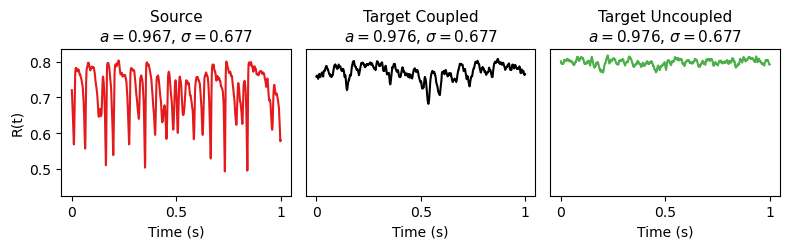

In [15]:
ini=185000
fini=205000
titles=['Source','Target Coupled','Target Uncoupled']
set_colors=[plt.get_cmap('Set1')(0),'k',plt.get_cmap('Set1')(2)]
plt.figure(figsize=(8,2.6))
for ii, i in enumerate([par_ids[0],par_ids[1],par_ids[1]]):
    plt.subplot(1,3,ii+1)
    plt.title(titles[ii]+'\n'+r'$a=%.3f$, $\sigma=%.3f$'%(a_par[i],sigma),fontsize=11)
    if ii==2:
        plt.plot(R[ini:fini,ii],color=set_colors[ii])
    else:
        plt.plot(R[ini:fini,ii],color=set_colors[ii])
    plt.ylim((0.425,0.835))
    if ii<1:
        plt.ylabel('R(t)')
    else:
        plt.yticks([])
    plt.xticks([0,10000,20000],['0','0.5','1'])
    plt.xlabel('Time (s)')
plt.tight_layout()
#plt.savefig('Figs/Timeseries_coupled1.pdf',transparent=True,dpi=300)
plt.show()


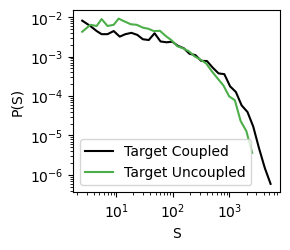

In [16]:
plt.figure(figsize=(3,2.6))
for ii, i in enumerate([par_ids[0],par_ids[1],par_ids[1]]):
    if ii>0:
        siz,dur=ava.measure_events(np.abs(R[:,ii]),threshold=np.median(np.abs(R[:,ii])),dir=-1)
        fx.plot_pdf(siz,color=set_colors[ii],label=titles[ii])
        plt.xlabel('S')
        plt.ylabel('P(S)')
plt.legend()
# plot fit
# exponent_s = -1.5 
# x_vals = np.array([200, 5000], dtype=float)
# A = 3e1  # Adjust this constant for visibility
# y_vals = A * x_vals**exponent_s
# plt.plot(x_vals, y_vals, 'k--')
# plt.text(500,0.005,fr'$\propto S^{{{exponent_s}}}$')

plt.tight_layout()
#plt.savefig('Figs/PowerlawS_coupled1.pdf',transparent=True, dpi=300)
plt.show()

In [17]:
par_ids=[6,0]

# super to sub
for ia in [par_ids[0]]:
    print(ia)
    for ib in [par_ids[1]]:
        # COUPLED 
        fname = f"data_a{ia}_b{ib}.pkl"
        fpath = os.path.join(out_folder, fname)  # Replace with your folder path
        if not os.path.exists(fpath):
            continue
        with open(fpath, 'rb') as f:
            data = pickle.load(f)
        R = data['R']
        if R.shape[0] < 1000:
            continue  # skip too short timeseries

        # UNCOUPLED
        fname = f"data_a{ib}_b{ib}.pkl"
        fpath = os.path.join(out_folder, fname)  # Replace with your folder path
        if not os.path.exists(fpath):
            continue
        with open(fpath, 'rb') as f:
            data_un = pickle.load(f)
        R_un = data_un['R'][:,0]
        
        R = np.hstack((R, R_un.reshape(-1, 1))) # this contains R_A, R_B, and R_B uncoupled (R_A for the parameters B)
        

        # Split into non-overlapping windows of 10,000 pts
        def split_windows(signal, window_size=10000):
            n = len(signal) // window_size
            return np.array_split(signal[:n * window_size], n)
        R_windows=[]
        for i in range(len(R[0])):
            R_windows.append(split_windows(R[:,i]))
        R_windows=np.swapaxes(np.swapaxes(np.asarray(R_windows),0,2),0,1)

6


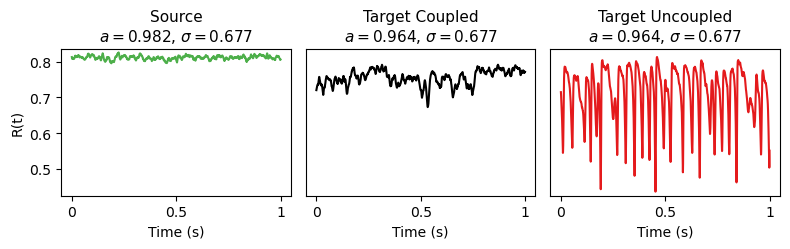

In [18]:
ini=185000
fini=205000
titles=['Source','Target Coupled','Target Uncoupled']
set_colors=[plt.get_cmap('Set1')(2),'k',plt.get_cmap('Set1')(0)]
plt.figure(figsize=(8,2.6))
for ii, i in enumerate([par_ids[0],par_ids[1],par_ids[1]]):
    plt.subplot(1,3,ii+1)
    plt.title(titles[ii]+'\n'+r'$a=%.3f$, $\sigma=%.3f$'%(a_par[i],sigma),fontsize=11)
    if ii==2:
        plt.plot(R[ini:fini,ii],color=set_colors[ii])
    else:
        plt.plot(R[ini:fini,ii],color=set_colors[ii])
    plt.ylim((0.425,0.835))
    if ii<1:
        plt.ylabel('R(t)')
    else:
        plt.yticks([])
    plt.xticks([0,10000,20000],['0','0.5','1'])
    plt.xlabel('Time (s)')
plt.tight_layout()
#plt.savefig('Figs/Timeseries_coupled2.pdf',transparent=True,dpi=300)
plt.show()


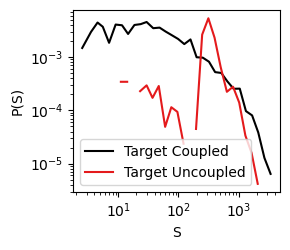

In [19]:
plt.figure(figsize=(3,2.6))
for ii, i in enumerate([par_ids[0],par_ids[1],par_ids[1]]):
    if ii>0:
        siz,dur=ava.measure_events(np.abs(R[:,ii]),threshold=np.median(np.abs(R[:,ii])),dir=-1)
        fx.plot_pdf(siz,color=set_colors[ii],label=titles[ii])
        plt.xlabel('S')
        plt.ylabel('P(S)')
plt.legend()
# plot fit
# exponent_s = -1.5 
# x_vals = np.array([200, 5000], dtype=float)
# A = 3e1  # Adjust this constant for visibility
# y_vals = A * x_vals**exponent_s
# plt.plot(x_vals, y_vals, 'k--')
# plt.text(500,0.005,fr'$\propto S^{{{exponent_s}}}$')

plt.tight_layout()
#plt.savefig('Figs/PowerlawS_coupled2.pdf',transparent=True, dpi=300)
plt.show()

In [20]:
par_ids=[3,3]

# super to sub
for ia in [par_ids[0]]:
    print(ia)
    for ib in [par_ids[1]]:
        # COUPLED 
        fname = f"data_a{ia}_b{ib}.pkl"
        fpath = os.path.join(out_folder, fname)  # Replace with your folder path
        if not os.path.exists(fpath):
            continue
        with open(fpath, 'rb') as f:
            data = pickle.load(f)
        R = data['R']
        if R.shape[0] < 1000:
            continue  # skip too short timeseries

        # UNCOUPLED
        fname = f"data_a{ib}_b{ib}.pkl"
        fpath = os.path.join(out_folder, fname)  # Replace with your folder path
        if not os.path.exists(fpath):
            continue
        with open(fpath, 'rb') as f:
            data_un = pickle.load(f)
        R_un = data_un['R'][:,0]
        
        R = np.hstack((R, R_un.reshape(-1, 1))) # this contains R_A, R_B, and R_B uncoupled (R_A for the parameters B)
        

        # Split into non-overlapping windows of 10,000 pts
        def split_windows(signal, window_size=10000):
            n = len(signal) // window_size
            return np.array_split(signal[:n * window_size], n)
        R_windows=[]
        for i in range(len(R[0])):
            R_windows.append(split_windows(R[:,i]))
        R_windows=np.swapaxes(np.swapaxes(np.asarray(R_windows),0,2),0,1)

3


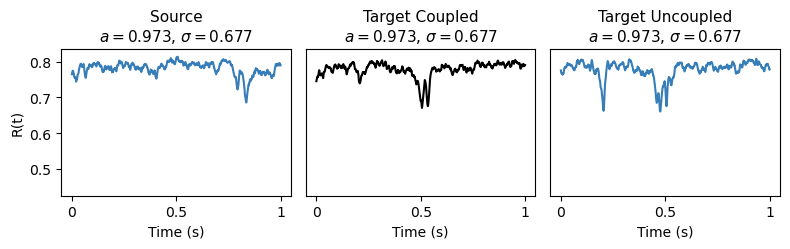

In [21]:
ini=185000
fini=205000
titles=['Source','Target Coupled','Target Uncoupled']
set_colors=[plt.get_cmap('Set1')(1),'k',plt.get_cmap('Set1')(1)]
plt.figure(figsize=(8,2.6))
for ii, i in enumerate([par_ids[0],par_ids[1],par_ids[1]]):
    plt.subplot(1,3,ii+1)
    plt.title(titles[ii]+'\n'+r'$a=%.3f$, $\sigma=%.3f$'%(a_par[i],sigma),fontsize=11)
    if ii==0:
        plt.plot(R[ini+85000:fini+85000,ii],color=set_colors[ii])
    elif ii==2:
        plt.plot(R[ini:fini,ii],color=set_colors[ii])
    else:
        plt.plot(R[ini:fini,ii],color=set_colors[ii])
    plt.ylim((0.425,0.835))
    if ii<1:
        plt.ylabel('R(t)')
    else:
        plt.yticks([])
    plt.xticks([0,10000,20000],['0','0.5','1'])
    plt.xlabel('Time (s)')
plt.tight_layout()
#plt.savefig('../figures/Timeseries_coupled3.pdf',transparent=True,dpi=300)
plt.show()


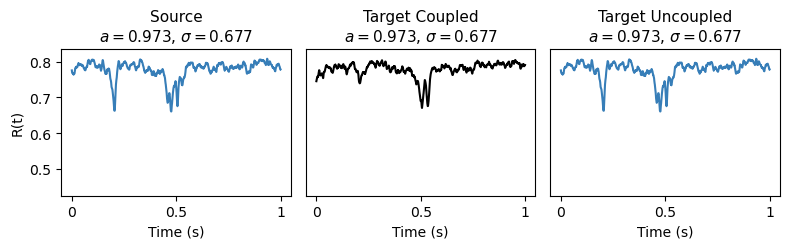

In [76]:
ini=185000
fini=205000
titles=['Source','Target Coupled','Target Uncoupled']
set_colors=[plt.get_cmap('Set1')(1),'k',plt.get_cmap('Set1')(1)]
plt.figure(figsize=(8,2.6))
for ii, i in enumerate([par_ids[0],par_ids[1],par_ids[1]]):
    plt.subplot(1,3,ii+1)
    plt.title(titles[ii]+'\n'+r'$a=%.3f$, $\sigma=%.3f$'%(a_par[i],sigma),fontsize=11)
    if ii==2:
        plt.plot(R[ini:fini,ii],color=set_colors[ii])
    else:
        plt.plot(R[ini:fini,ii],color=set_colors[ii])
    plt.ylim((0.425,0.835))
    if ii<1:
        plt.ylabel('R(t)')
    else:
        plt.yticks([])
    plt.xticks([0,10000,20000],['0','0.5','1'])
    plt.xlabel('Time (s)')
plt.tight_layout()
#xplt.savefig('Figs/Timeseries_coupled3.pdf',transparent=True,dpi=300)
plt.show()


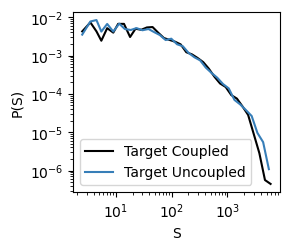

In [22]:
plt.figure(figsize=(3,2.6))
for ii, i in enumerate([par_ids[0],par_ids[1],par_ids[1]]):
    if ii>0:
        siz,dur=ava.measure_events(np.abs(R[:,ii]),threshold=np.median(np.abs(R[:,ii])),dir=-1)
        fx.plot_pdf(siz,color=set_colors[ii],label=titles[ii])
        plt.xlabel('S')
        plt.ylabel('P(S)')
plt.legend()
# plot fit
# exponent_s = -1.5 
# x_vals = np.array([200, 5000], dtype=float)
# A = 3e1  # Adjust this constant for visibility
# y_vals = A * x_vals**exponent_s
# plt.plot(x_vals, y_vals, 'k--')
# plt.text(500,0.005,fr'$\propto S^{{{exponent_s}}}$')

plt.tight_layout()
#plt.savefig('Figs/PowerlawS_coupled3.pdf',transparent=True, dpi=300)
plt.show()